In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

Load the Ice Age data in the `genosnp` format:

In [3]:
genosnp = pd.concat([pd.read_table('../raw_data/ice_age/genosnp_first_500000.gz', sep=' ', header=None, na_values='-'),
                     pd.read_table('../raw_data/ice_age/genosnp_last_454456.gz', sep=' ', header=None, na_values='-')])
genosnp.columns = ['chrom', 'pos', 'id', 'genpos', 'allele0', 'allele1', 'bin', 'gt_string', 'bvalue']

In [4]:
genosnp['end'] = genosnp.pos
genosnp['start'] = genosnp.pos - 1

Ignore sites that don't have a B-value annotation:

In [5]:
genosnp = genosnp.dropna()

# now that the NaNs are gone, bins can be integers
genosnp.bin = genosnp.bin.astype(int)

### Distribution of B-values of the archaic informative sites

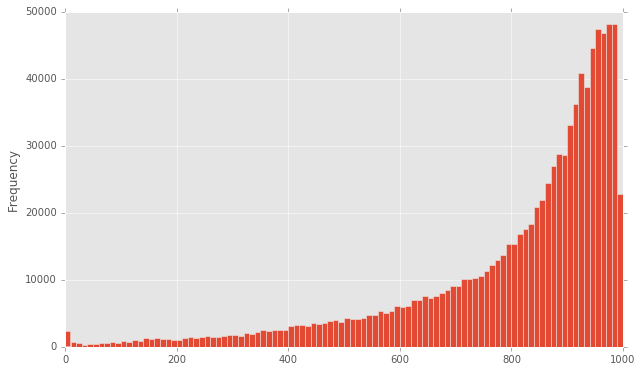

In [94]:
genosnp.bvalue.plot(kind='hist', xlim=(0, 1000), bins=100)

### Distribution of B-value bins, as binned by the Reich's lab

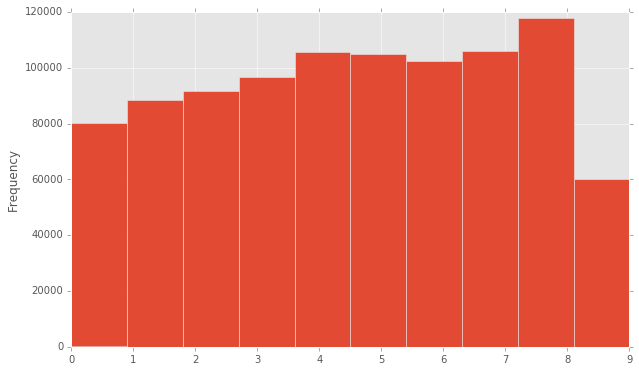

In [7]:
genosnp.bin.plot(kind='hist', xlim=(0, 9))

This distribution looks quite strange, as the sites were supposed to be binned into +/- equal-sizes bins?

What if we bin the sites ourselves? How does the distribution look like then?

In [57]:
quantiles = genosnp.bvalue.quantile(np.arange(0, 1, 0.1))

In [8]:
n_bins = 10
bin_labels = list(range(n_bins))
our_bins = pd.qcut(genosnp.bvalue, n_bins, labels=bin_labels).astype(int)

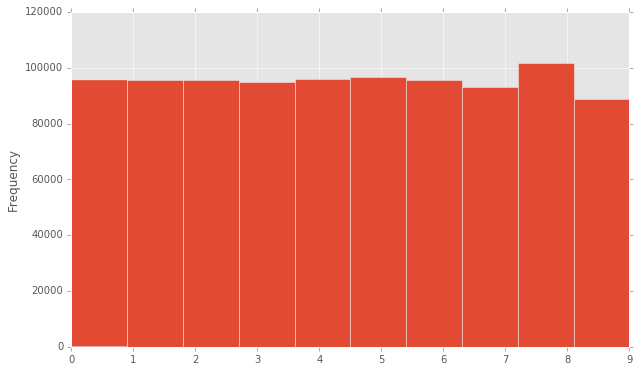

In [9]:
our_bins.plot(kind='hist', xlim=(0, 9))

In [10]:
genosnp.bin = our_bins

I think I'm going to trust these bins a little bit more...

## What is a relationship between B-value of a site and its distance to the nearest exon?

In [11]:
from pybedtools import BedTool

Download the genome annotations and subset to exons only:

In [12]:
gtf = pd.read_table('ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz',
                    header=None, sep='\t', skipinitialspace=True, skiprows=5, compression='gzip',
                    names=['chrom', 'source', 'feature', 'start', 'end',
                           'score', 'strand', 'frame', 'attribute'], low_memory=False)

In [97]:
gtf.head()

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
3,1,processed_transcript,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
4,1,processed_transcript,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [13]:
gtf.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

In [14]:
exons = BedTool.from_dataframe(
    gtf[(gtf.source == "protein_coding") &
        (gtf.feature == "exon")]
).sort().merge()

Find the distance of each site from the admixture array to the nearest exon:

In [16]:
distances = BedTool.from_dataframe(genosnp[['chrom', 'start', 'end']]).sort() \
                .closest(exons, t='first', d=True).to_dataframe()[[-1]].values
genosnp['exon_distance'] = distances

## Exons

### B-value of a site vs its distance to the nearest exon¶

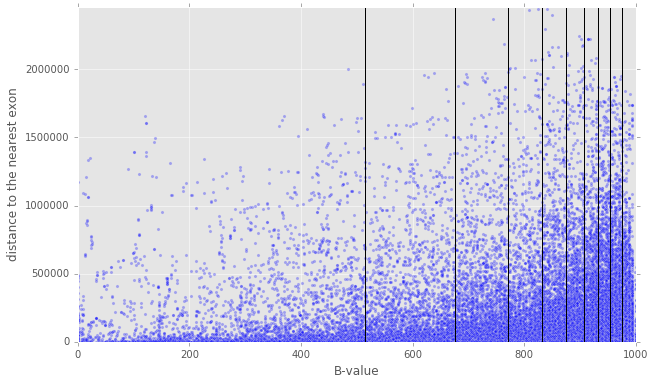

In [84]:
plt.scatter('bvalue', 'exon_distance', data=genosnp.sample(50000), alpha=0.3, s=10)

plt.xlim(0, 1000)
plt.ylim(0, max(genosnp.exon_distance))

plt.xlabel('B-value')
plt.ylabel('distance to the nearest exon')

plt.vlines(quantiles, ymin=0, ymax=max(genosnp.exon_distance))

### Mean distance to the nearest exon for any given B-value

In [65]:
avg_distances = genosnp.groupby('bvalue')['exon_distance'].mean()

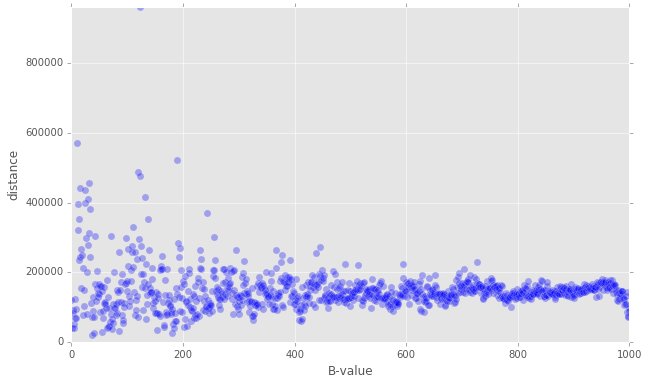

In [66]:
plt.scatter(avg_distances.index, avg_distances, alpha=0.3, s=50)

plt.xlim(0, 1000)
plt.ylim(0, max(avg_distances))

plt.xlabel('B-value')
plt.ylabel('distance')

### Mean distance to the nearest exon for any given B-value *bin*

In [77]:
bin_distances = genosnp.groupby('bin')['exon_distance']

In [80]:
bins = [g.sample(1000) for _, g in bin_distances]

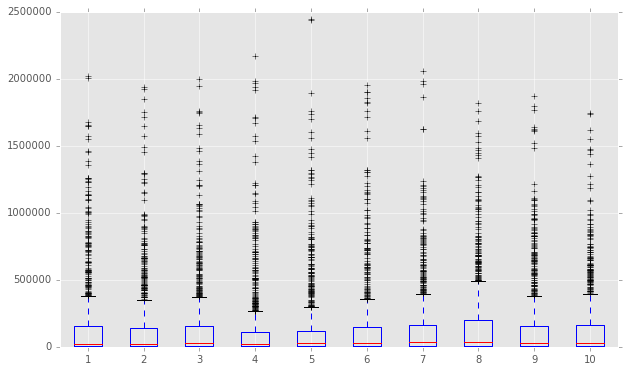

In [91]:
_ = plt.boxplot(bins)

In [87]:
for i in range(10):
    print(i, '\t', genosnp.query('bin == {}'.format(i)).exon_distance.mean())

0 	 147413.915738
1 	 136639.124645
2 	 154414.734639
3 	 135761.896255
4 	 142517.816374
5 	 144946.984192
6 	 151452.106061
7 	 155294.42754
8 	 160474.753579
9 	 130815.549908


In [95]:
for i in range(10):
    print(i, '\t', genosnp.query('bin == {}'.format(i)).exon_distance.median())

0 	 21834.5
1 	 21961.0
2 	 26382.0
3 	 22735.0
4 	 25205.0
5 	 29385.0
6 	 32025.0
7 	 31410.0
8 	 29556.5
9 	 25572.5


In [102]:
for i in range(10):
    print(i, '\t', genosnp.query('bin == {}'.format(i)).exon_distance.quantile(0.1))

0 	 432.3
1 	 483.0
2 	 598.0
3 	 560.0
4 	 624.0
5 	 690.0
6 	 740.0
7 	 711.0
8 	 619.0
9 	 599.0
